In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import fiona
from matplotlib import pyplot as plt
from shapely.geometry import polygon
%matplotlib inline

# Writing Aggregate Map Files

This notebook's objectives were to read in the Emissions Scenario GeoDataFrames saved in notebook 1, then to create a series of GeoDataFrames that can map the number of species whose ranges overlap for every area covered by the study.

## Reading and Formatting the Data

In [2]:
# establishing our coordinates from the base data
mapcrs = gpd.read_file('./bird-species/E00028800_cackling_canada_goose.gdb/').crs

In [3]:
# checking that the crs is the same across all base data
print(gpd.read_file('./bird-species/E00028800_cackling_canada_goose.gdb/').crs)
print(gpd.read_file('./bird-species/E00079600_gambels_quail.gdb/').crs)
print(gpd.read_file('./bird-species/E00051600_king_eider.gdb/').crs)

{'proj': 'aea', 'lat_1': 20, 'lat_2': 60, 'lat_0': 40, 'lon_0': -96, 'x_0': 0, 'y_0': 0, 'datum': 'NAD83', 'units': 'm', 'no_defs': True}
{'proj': 'aea', 'lat_1': 20, 'lat_2': 60, 'lat_0': 40, 'lon_0': -96, 'x_0': 0, 'y_0': 0, 'datum': 'NAD83', 'units': 'm', 'no_defs': True}
{'proj': 'aea', 'lat_1': 20, 'lat_2': 60, 'lat_0': 40, 'lon_0': -96, 'x_0': 0, 'y_0': 0, 'datum': 'NAD83', 'units': 'm', 'no_defs': True}


In [4]:
# reading our data files into an iterable dictionary
study_list = {
    'summer_00':gpd.GeoDataFrame.from_file('./birds-data/2000_suitability_kappa_BBS/'),
    'winter_00':gpd.GeoDataFrame.from_file('./birds-data/2000_suitability_kappa_CBC/'),
    'summer_20':gpd.GeoDataFrame.from_file('./birds-data/2020_A2_suitability_kappa_BBS/'),
    'winter_20':gpd.GeoDataFrame.from_file('./birds-data/2020_A2_suitability_kappa_CBC/'),
    'summer_50':gpd.GeoDataFrame.from_file('./birds-data/2050_A2_suitability_kappa_BBS/'),
    'winter_50':gpd.GeoDataFrame.from_file('./birds-data/2050_A2_suitability_kappa_CBC/'),
    'summer_80':gpd.GeoDataFrame.from_file('./birds-data/2080_A2_suitability_kappa_BBS/'),
    'winter_80':gpd.GeoDataFrame.from_file('./birds-data/2080_A2_suitability_kappa_CBC/')
}

In [5]:
# making sure everything's there
study_list.keys()

dict_keys(['summer_00', 'winter_00', 'summer_20', 'winter_20', 'summer_50', 'winter_50', 'summer_80', 'winter_80'])

In [6]:
# seeing if the files were read in with coordinate system information
study_list['summer_00'].crs

{}

In [7]:
# setting the coordinates to those of the base bird species data
for gdf in study_list.values():
    gdf.crs = {'proj': 'aea',
 'lat_1': 20,
 'lat_2': 60,
 'lat_0': 40,
 'lon_0': -96,
 'x_0': 0,
 'y_0': 0,
 'datum': 'NAD83',
 'units': 'm',
 'no_defs': True}

In [8]:
# ...and confirming. Much better!
study_list['summer_00'].crs

{'proj': 'aea',
 'lat_1': 20,
 'lat_2': 60,
 'lat_0': 40,
 'lon_0': -96,
 'x_0': 0,
 'y_0': 0,
 'datum': 'NAD83',
 'units': 'm',
 'no_defs': True}

## EDA

Ensuring that the GeoDataFrames are formatted correctly and that the polygons can map normally. These checks helped ensure that the next stage of the process worked.

In [9]:
# looking at the data
study_list['summer_00'].head()

,value,Shape_Leng,Shape_Area,geometry
0,1.0,5500000.0,7.410000e+10,"(POLYGON ((-1844911.2311 -655519.5457000006, -..."
1,1.0,121380000.0,2.459500e+12,(POLYGON ((-834911.2311000004 -705519.54569999...
2,1.0,103120000.0,2.774100e+12,"(POLYGON ((-1854911.2311 2274480.454299999, -1..."
3,1.0,15100000.0,1.159300e+12,"(POLYGON ((335088.7688999996 -1165519.5457, 34..."
4,1.0,1640000.0,1.120000e+10,"(POLYGON ((1755088.7689 -1555519.5457, 1765088..."


In [10]:
# looking a bit more at the data
study_list['summer_00'].info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 470 entries, 0 to 469
Data columns (total 4 columns):
value         470 non-null float64
Shape_Leng    470 non-null float64
Shape_Area    470 non-null float64
geometry      470 non-null object
dtypes: float64(3), object(1)
memory usage: 14.8+ KB


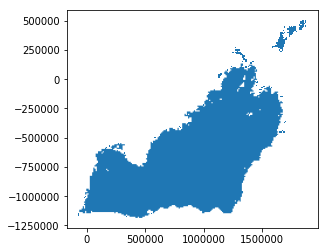

In [11]:
# example of one of our polygons
gpd.GeoDataFrame(study_list['summer_00'].loc[[3]]).plot()

In [12]:
# checking the data type. This should wrap up this round of EDA!
type(study_list['summer_00'].geometry[0])

shapely.geometry.multipolygon.MultiPolygon

## Testing Aggregate Map Workflow

Iterating over manually-drawn polygon "pixels" in a _very_ coarse map for one of my imported GeoDataFrames. Then I can scale these steps to more useful maps depicting how many species live in the different areas in North America

In [13]:
# to iterate over the relevant map area, I'll have the find the highest and lowest
# lattitude and longitude values for the whole dataframe (-4.164911e+06)
sorted_sum00 = study_list['summer_00'].bounds.sort_values('minx',ascending=True)['minx']
minx = sorted_sum00.reset_index(drop=True)[0]

sorted_sum00 = study_list['summer_00'].bounds.sort_values('maxx',ascending=False)['maxx']
maxx = sorted_sum00.reset_index(drop=True)[0]

sorted_sum00 = study_list['summer_00'].bounds.sort_values('miny',ascending=True)['miny']
miny = sorted_sum00.reset_index(drop=True)[0]

sorted_sum00 = study_list['summer_00'].bounds.sort_values('maxy',ascending=False)['maxy']
maxy = sorted_sum00.reset_index(drop=True)[0]

[(minx,maxx),(miny,maxy)]

[(-4164911.2311000004, 2995088.7688999996),
 (-1645519.5456999997, 4514480.454299999)]

In [14]:
# testing with big pixels
xpoints = np.linspace(minx,maxx,num=12)
ypoints = np.linspace(miny,maxy,num=12)

big_pix = []
for x in range(len(xpoints)-1):
    for y in range(len(ypoints)-1):
        big_pix.append(polygon.Polygon([(xpoints[x],ypoints[y]),
                                       (xpoints[x+1],ypoints[y]),
                                       (xpoints[x+1],ypoints[y+1]),
                                       (xpoints[x],ypoints[y+1])]))
        if ((x + y) % 10 == 0):
            print(f'building pixel at ({x},{y})')
        
big_pix = gpd.GeoDataFrame(geometry = big_pix,crs=mapcrs)
big_pix['count'] = 0
big_pix.head()

building pixel at (0,0)
building pixel at (0,10)
building pixel at (1,9)
building pixel at (2,8)
building pixel at (3,7)
building pixel at (4,6)
building pixel at (5,5)
building pixel at (6,4)
building pixel at (7,3)
building pixel at (8,2)
building pixel at (9,1)
building pixel at (10,0)
building pixel at (10,10)


,geometry,count
0,"POLYGON ((-4164911.2311 -1645519.5457, -351400...",0
1,"POLYGON ((-4164911.2311 -1085519.5457, -351400...",0
2,"POLYGON ((-4164911.2311 -525519.5456999999, -3...",0
3,"POLYGON ((-4164911.2311 34480.45429999987, -35...",0
4,"POLYGON ((-4164911.2311 594480.4542999999, -35...",0


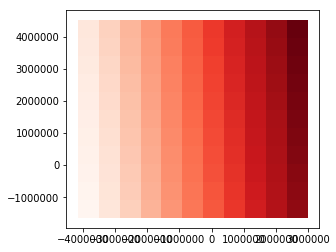

In [15]:
# making sure our pixels cover an area
big_pix.plot(cmap='Reds')

In [16]:
# iterating and assigning the count value of how many species' ranges fall in a pixel's
# area
for pixel in range(len(big_pix)):
    count = 0
    for species in range(len(study_list['summer_00'])):
        count += gpd.GeoSeries(
            big_pix['geometry'].loc[pixel]).intersects(study_list['summer_00']
                                                       ['geometry'][species])
    big_pix['count'][pixel] = count
    if (pixel % 11 == 0):
        print(f'counting species for pixel {pixel}')
    
big_pix.head(10)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


counting species for pixel 0
counting species for pixel 11
counting species for pixel 22
counting species for pixel 33
counting species for pixel 44
counting species for pixel 55
counting species for pixel 66
counting species for pixel 77
counting species for pixel 88
counting species for pixel 99
counting species for pixel 110


,geometry,count
0,"POLYGON ((-4164911.2311 -1645519.5457, -351400...",0
1,"POLYGON ((-4164911.2311 -1085519.5457, -351400...",0
2,"POLYGON ((-4164911.2311 -525519.5456999999, -3...",0
3,"POLYGON ((-4164911.2311 34480.45429999987, -35...",0
4,"POLYGON ((-4164911.2311 594480.4542999999, -35...",0
5,"POLYGON ((-4164911.2311 1154480.4543, -3514002...",0
6,"POLYGON ((-4164911.2311 1714480.454299999, -35...",0
7,"POLYGON ((-4164911.2311 2274480.454299999, -35...",0
8,"POLYGON ((-4164911.2311 2834480.454299999, -35...",95
9,"POLYGON ((-4164911.2311 3394480.454299999, -35...",65


In [17]:
# checking the crs again. This is very important for visualizing my maps!
big_pix.crs

{'proj': 'aea',
 'lat_1': 20,
 'lat_2': 60,
 'lat_0': 40,
 'lon_0': -96,
 'x_0': 0,
 'y_0': 0,
 'datum': 'NAD83',
 'units': 'm',
 'no_defs': True}

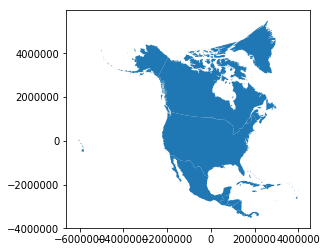

In [18]:
# Here I begin using a map I pulled in from another source https://geojson-maps.ash.ms/
northam = gpd.read_file('./NorthAm.json')
northam = northam.to_crs(mapcrs)
northam.plot()

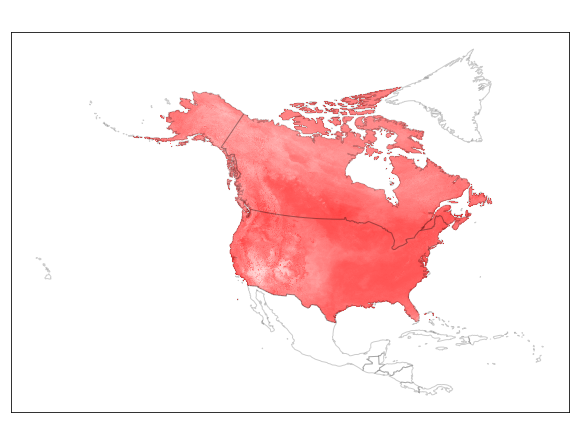

In [58]:
# Mapping the species overlap of the 2000 BBS somewhat hollistically, using 'alpha'
# to darken the colors where more species were observed
fig,ax = plt.subplots(1,1,sharex=True,sharey=True,figsize=(10,7))

study_list['summer_00'].plot(ax=ax,color='red',alpha=.02);
northam.plot(ax=ax,color='white', edgecolor='black',alpha=0.2);
plt.title('All Species\' Range Overlaps, Summer 2000',fontsize=24,color='white');
plt.axis('tight');
plt.xticks([]);
plt.yticks([]);
plt.show();

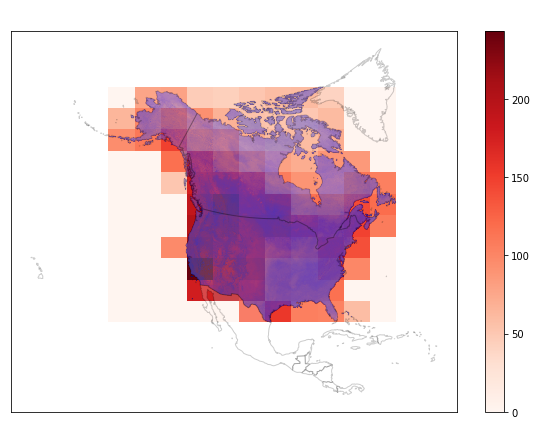

In [62]:
# and finally checking our test map with our 12x12 grid of bird species counts
fig,ax = plt.subplots(1,1,sharex=True,sharey=True,figsize=(10,7))

big_pix.plot(ax=ax,cmap='Reds',column='count',legend=True);

study_list['summer_00'].plot(ax=ax,color='blue',alpha=.01);
northam.plot(ax=ax,color='white', edgecolor='black',alpha=0.2);
plt.axis('tight');
plt.xticks([]);
plt.yticks([]);
plt.title('Species Range Count Overlapped',color='white',fontsize=24);
plt.show();

## Making study/count map files

Since I have the process down (for the coarse-pixel version), now I can make my fine-grained "raster" maps for each study!

### Warning

This operation takes a long time. Even the 100x100 grid took about 12 hours on my computer. Once again, if you are interested in reproducing the work I suggest either setting aside the necessary time or interrupting the process once you see it running and then using the files already saved in the repository.

In [21]:
# I'll make one file for each climate study
for study in study_list:
    print(f'generating map for {study} study.')

    # to iterate over the relevant map area, I'll have the find the highest and lowest
    # lattitude and longitude values for the whole GeoDataFrame
    sorted_study = study_list[study].bounds.sort_values('minx',ascending=True)['minx']
    minx = sorted_study.reset_index(drop=True)[0]

    sorted_study = study_list[study].bounds.sort_values('maxx',ascending=False)['maxx']
    maxx = sorted_study.reset_index(drop=True)[0]

    sorted_study = study_list[study].bounds.sort_values('miny',ascending=True)['miny']
    miny = sorted_study.reset_index(drop=True)[0]

    sorted_study = study_list[study].bounds.sort_values('maxy',ascending=False)['maxy']
    maxy = sorted_study.reset_index(drop=True)[0]
    
    # 100x100 pixels will still be very grainy, but going much higher put my computing
    # times as longer than my deadline allows. Oops.
    xpoints = np.linspace(minx,maxx,num=100)
    ypoints = np.linspace(miny,maxy,num=100)

    # creating each pixel and putting it into a list
    pix = []
    for x in range(len(xpoints)-1):
        for y in range(len(ypoints)-1):
            pix.append(polygon.Polygon([(xpoints[x],ypoints[y]),
                                           (xpoints[x+1],ypoints[y]),
                                           (xpoints[x+1],ypoints[y+1]),
                                           (xpoints[x],ypoints[y+1])]))

    # turning that list into a GeoDataFrame, adding our 'count' column
    pix = gpd.GeoDataFrame(geometry = pix,crs=mapcrs)
    pix['count'] = 0
    
    # iterating and assigning the count value of how many species' ranges fall in a
    # pixel's area
    for pixel in range(len(pix)):
        count = 0
        for species in range(len(study_list[study])):
            # since .intersects() returns a list of boolean values and Python counts
            # True values as 1, this ended up being an easier operation than I thought!
            count += gpd.GeoSeries(
                pix['geometry'].loc[pixel]).intersects(study_list[study]
                                                       ['geometry'][species])
        pix['count'][pixel] = count
        if (pixel % 100 == 0):
            print(f'counting species for pixel {pixel}')
    # saving each output
    pix.to_file(f'./birds-data/{study}_agg')

generating map for summer_00 study.


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


counting species for pixel 0
counting species for pixel 100
counting species for pixel 200
counting species for pixel 300
counting species for pixel 400
counting species for pixel 500
counting species for pixel 600
counting species for pixel 700
counting species for pixel 800
counting species for pixel 900
counting species for pixel 1000
counting species for pixel 1100
counting species for pixel 1200
counting species for pixel 1300
counting species for pixel 1400
counting species for pixel 1500
counting species for pixel 1600
counting species for pixel 1700
counting species for pixel 1800
counting species for pixel 1900
counting species for pixel 2000
counting species for pixel 2100
counting species for pixel 2200
counting species for pixel 2300
counting species for pixel 2400
counting species for pixel 2500
counting species for pixel 2600
counting species for pixel 2700
counting species for pixel 2800
counting species for pixel 2900
counting species for pixel 3000
counting species for

/anaconda3/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


generating map for winter_00 study.
counting species for pixel 0
counting species for pixel 100
counting species for pixel 200
counting species for pixel 300
counting species for pixel 400
counting species for pixel 500
counting species for pixel 600
counting species for pixel 700
counting species for pixel 800
counting species for pixel 900
counting species for pixel 1000
counting species for pixel 1100
counting species for pixel 1200
counting species for pixel 1300
counting species for pixel 1400
counting species for pixel 1500
counting species for pixel 1600
counting species for pixel 1700
counting species for pixel 1800
counting species for pixel 1900
counting species for pixel 2000
counting species for pixel 2100
counting species for pixel 2200
counting species for pixel 2300
counting species for pixel 2400
counting species for pixel 2500
counting species for pixel 2600
counting species for pixel 2700
counting species for pixel 2800
counting species for pixel 2900
counting species

counting species for pixel 5600
counting species for pixel 5700
counting species for pixel 5800
counting species for pixel 5900
counting species for pixel 6000
counting species for pixel 6100
counting species for pixel 6200
counting species for pixel 6300
counting species for pixel 6400
counting species for pixel 6500
counting species for pixel 6600
counting species for pixel 6700
counting species for pixel 6800
counting species for pixel 6900
counting species for pixel 7000
counting species for pixel 7100
counting species for pixel 7200
counting species for pixel 7300
counting species for pixel 7400
counting species for pixel 7500
counting species for pixel 7600
counting species for pixel 7700
counting species for pixel 7800
counting species for pixel 7900
counting species for pixel 8000
counting species for pixel 8100
counting species for pixel 8200
counting species for pixel 8300
counting species for pixel 8400
counting species for pixel 8500
counting species for pixel 8600
counting

counting species for pixel 1300
counting species for pixel 1400
counting species for pixel 1500
counting species for pixel 1600
counting species for pixel 1700
counting species for pixel 1800
counting species for pixel 1900
counting species for pixel 2000
counting species for pixel 2100
counting species for pixel 2200
counting species for pixel 2300
counting species for pixel 2400
counting species for pixel 2500
counting species for pixel 2600
counting species for pixel 2700
counting species for pixel 2800
counting species for pixel 2900
counting species for pixel 3000
counting species for pixel 3100
counting species for pixel 3200
counting species for pixel 3300
counting species for pixel 3400
counting species for pixel 3500
counting species for pixel 3600
counting species for pixel 3700
counting species for pixel 3800
counting species for pixel 3900
counting species for pixel 4000
counting species for pixel 4100
counting species for pixel 4200
counting species for pixel 4300
counting